# Clasificación de cyberbullying

- Dataset: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

## 1.- Conjuntos de entrenamiento, validación y prueba

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('cyberbullying_train.csv')  
val_df = pd.read_csv('cyberbullying_val.csv')  
test_df = pd.read_csv('cyberbullying_test.csv')  

## 2.- Preprocesamiento

In [3]:
# Creamos un diccionario que mapea cada etiqueta a un número entero
labels_dict = {
    'not_cyberbullying': 0,
    'gender': 1,
    'religion': 2,
    'other_cyberbullying': 3,
    'age': 4,
    'ethnicity': 5
}

# Usamos la función map() para reemplazar cada etiqueta con su valor entero correspondiente
train_df['cyberbullying_type'] = train_df['cyberbullying_type'].replace(labels_dict)
val_df['cyberbullying_type'] = val_df['cyberbullying_type'].replace(labels_dict)
test_df['cyberbullying_type'] = test_df['cyberbullying_type'].replace(labels_dict)

train_df.head()

,tweet_text,cyberbullying_type
0,@AntonSirius @erinspice @prpltnkr @ChiefElk oh...,3
1,"Ladies ""Bedroom Bully"" The Mix Cd By @GappyRan...",0
2,RT @_bobbidana: Never thought I'd say this but...,0
3,She is intellectual terrorists and world suffe...,2
4,You saudias are not friends of Muslim idiots c...,2


- Verifica cadenas vacias

In [4]:
train_df['tweet_text'].isna().sum()

0

- Elimina puntuación y convierte a minúsculas
- Se utiliza el método __str.translate()__ para eliminar todos los caracteres de puntuación mediante una tabla de traducción creada con el método __str.maketrans__. La constante string.punctuation contiene todos los caracteres de puntuación ASCII, que se eliminan de los valores en la columna

In [5]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [6]:
train_df['tweet_text'] = train_df['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
train_df.head()

,tweet_text,cyberbullying_type
0,antonsirius erinspice prpltnkr chiefelk oh dea...,3
1,ladies bedroom bully the mix cd by gappyranks ...,0
2,rt bobbidana never thought id say this but i h...,0
3,she is intellectual terrorists and world suffe...,2
4,you saudias are not friends of muslim idiots c...,2


In [7]:
val_df['tweet_text'] = val_df['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
val_df.head()

,tweet_text,cyberbullying_type
0,but you idiot tagged and more also im a muslim,2
1,sexylala thats a dumb nigger never fuck lala h...,5
2,i never hear hispanics calling each other brow...,5
3,lennybanx nigger read it again such a dumb ass...,5
4,she was a mean girl in high school she and mim...,4


In [8]:
test_df['tweet_text'] = test_df['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
test_df.head()

,tweet_text,cyberbullying_type
0,dankmtl yeap as a little propaganda nazi for t...,2
1,lyndseyboo wow leave lyndsey phone alone bully...,3
2,im not a man only know how to bully people,3
3,urgedharry nyazpolitics greenlinerzjm if you a...,2
4,calling people dumb isnt nice rt tayyoung fuc...,5


## 2.- Pipeline

In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras import layers 
import re

X_train = train_df['tweet_text'].values
y_train = train_df['cyberbullying_type'].values

X_val = val_df['tweet_text'].values
y_val = val_df['cyberbullying_type'].values

X_test = test_df['tweet_text'].values
y_test = test_df['cyberbullying_type'].values

In [10]:
len(X_train), len(X_val), len(X_test)

(33384, 7154, 7154)

In [11]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
raw_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

for text in raw_train_ds.take(1):
    print(text)

(<tf.Tensor: shape=(), dtype=string, numpy=b'antonsirius erinspice prpltnkr chiefelk oh dear lord'>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)


In [12]:
# Tamaño de vocabulario
vocab_size = 10000

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode='tf-idf')

# Obtener el texto sin etiquetas
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [13]:
# Define a function to convert the label to a one-hot encoding
def convert_label_to_one_hot(text, label):
    one_hot_label = tf.one_hot(label, 6)
    return text, one_hot_label

# Apply the function to the dataset using map()
raw_train_ds = raw_train_ds.map(convert_label_to_one_hot)
raw_val_ds = raw_val_ds.map(convert_label_to_one_hot)
raw_test_ds = raw_test_ds.map(convert_label_to_one_hot)

In [14]:
batch_size = 32
train_ds = raw_train_ds.shuffle(33384).batch(batch_size)
val_ds = raw_val_ds.batch(batch_size)
test_ds = raw_test_ds.batch(batch_size)

In [15]:
for inp, target in train_ds.take(1):
    print(inp, target)

tf.Tensor(
[b'chickfila caves to radical left bullies the american family association afa has created a petition that urges chickfila to return to its support of christian ministries such as the salvation army on monday chickfila anno\xe2\x80\xa6httpslnkdingnjakt'
 b'i am the middle school bully nobody fucks with me'
 b'annlynzee minorities are abusedharassed more and being a victim of harassment can make people act ways they normally wouldnt'
 b'ya just dont understand how happy that fuck ass dumb ass ugly ass fat ass annoying ass nigger makes me'
 b'odd to cherry pick one incident to wave the race card and call out fictitious racism in the system race baiting findher'
 b'\xe2\x80\x9clocajae he everythinggggggg xx\xe2\x80\x9dbet he has sex with you and leaves to fuck his other bitches dumb nigger'
 b'thank you  somebody got some sense  black people were called \xe2\x80\x9ccolored\xe2\x80\x9d and \xe2\x80\x9cnegro\xe2\x80\x9d until the 1970s nobody else was called this  but now we all 

In [16]:
vectorize_layer(inp)

<tf.Tensor: shape=(32, 10000), dtype=float32, numpy=
array([[38.53385  ,  2.46711  ,  1.3331412, ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  1.233555 ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 7.70677  ,  0.       ,  1.3331412, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [30.82708  ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 7.70677  ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)>

## 3.- Modelo

In [17]:
class Linear(tf.keras.layers.Layer):
    def __init__(self, num_outputs, activation=None):
        super(Linear, self).__init__()
        self.num_outputs = num_outputs
        self.activation = activation

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                  shape=[int(input_shape[-1]), 
                                         self.num_outputs])
        self.bias = self.add_weight("bias",
                                shape=[1, self.num_outputs])

    def call(self, inputs):
        x = tf.matmul(inputs, self.kernel) + self.bias
        if self.activation == 'relu':
            x = tf.nn.relu(x)
        return x

layer = Linear(1)
layer

In [18]:
model = Sequential([
  vectorize_layer,
  layers.Dropout(0.5),
  Linear(50, activation='relu'),
  layers.Dropout(0.5),
  Linear(50, activation='relu'),
  layers.Dropout(0.5),
  Linear(6)
])

lr = 0.0001
opt = tf.keras.optimizers.Adam(learning_rate=lr)

In [19]:
model(inp).shape

TensorShape([32, 6])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 10000)            1         
 torization)                                                     
                                                                 
 dropout (Dropout)           (None, 10000)             0         
                                                                 
 linear_1 (Linear)           (None, 50)                500050    
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 linear_2 (Linear)           (None, 50)                2550      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                        

In [21]:
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [22]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=opt,
              metrics=['accuracy'])

In [23]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, callbacks=model_checkpoint_callback)

Epoch 1/20
1044/1044 [==============================] - 4s 3ms/step - loss: 1.8138 - accuracy: 0.2440 - val_loss: 1.4583 - val_accuracy: 0.5310
Epoch 2/20
1044/1044 [==============================] - 3s 3ms/step - loss: 1.4312 - accuracy: 0.4361 - val_loss: 0.9411 - val_accuracy: 0.7385
Epoch 3/20
1044/1044 [==============================] - 3s 3ms/step - loss: 1.1261 - accuracy: 0.5788 - val_loss: 0.6687 - val_accuracy: 0.7776
Epoch 4/20
1044/1044 [==============================] - 3s 3ms/step - loss: 0.9776 - accuracy: 0.6357 - val_loss: 0.5675 - val_accuracy: 0.7905
Epoch 5/20
1044/1044 [==============================] - 3s 3ms/step - loss: 0.8838 - accuracy: 0.6656 - val_loss: 0.5153 - val_accuracy: 0.8040
Epoch 6/20
1044/1044 [==============================] - 3s 3ms/step - loss: 0.8265 - accuracy: 0.6899 - val_loss: 0.4888 - val_accuracy: 0.8105
Epoch 7/20
1044/1044 [==============================] - 4s 3ms/step - loss: 0.8013 - accuracy: 0.6973 - val_loss: 0.4716 - val_accuracy:

In [24]:
model.load_weights(checkpoint_filepath)

## 4.- Evaluación

In [25]:
model.evaluate(test_ds)

224/224 [==============================] - 0s 1ms/step - loss: 0.4285 - accuracy: 0.8379


[0.42850202322006226, 0.837852954864502]

In [26]:
y_pred = model.predict(test_ds)

224/224 [==============================] - 0s 1ms/step


In [27]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [28]:
y_test

array([2, 3, 3, ..., 4, 4, 3])

In [29]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_labels

array([2, 0, 3, ..., 4, 4, 3])

In [30]:
labels_dict

{'not_cyberbullying': 0,
 'gender': 1,
 'religion': 2,
 'other_cyberbullying': 3,
 'age': 4,
 'ethnicity': 5}

In [31]:
labels_dict.keys(), 

(dict_keys(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying', 'age', 'ethnicity']),)

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_labels, target_names=labels_dict.keys()))

                     precision    recall  f1-score   support

  not_cyberbullying       0.62      0.57      0.59      1189
             gender       0.89      0.83      0.86      1141
           religion       0.95      0.95      0.95      1191
other_cyberbullying       0.65      0.71      0.68      1216
                age       0.94      0.98      0.96      1221
          ethnicity       0.97      0.98      0.98      1196

           accuracy                           0.84      7154
          macro avg       0.84      0.84      0.84      7154
       weighted avg       0.84      0.84      0.84      7154



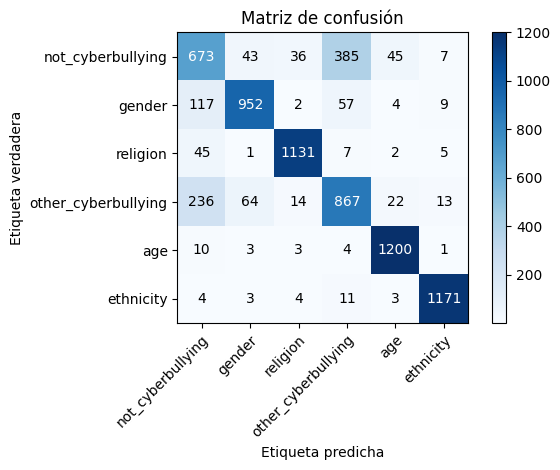

In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Crea la matriz de confusión
cm = confusion_matrix(y_test, y_pred_labels)

# Define las etiquetas de las clases
class_names = list(labels_dict.keys())

# Crea la figura y el eje
fig, ax = plt.subplots()

# Crea la matriz de colores
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Añade la barra de colores
cbar = ax.figure.colorbar(im, ax=ax)

# Añade las etiquetas de las clases
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       title='Matriz de confusión',
       ylabel='Etiqueta verdadera',
       xlabel='Etiqueta predicha')

# Rota las etiquetas de las clases
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Añade los valores de la matriz de confusión en cada celda
thresh = cm.max() / 2.  # Umbral para aplicar estilo de texto
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Ajusta el diseño de la figura
fig.tight_layout()
plt.savefig('cyber_cm.png')
# Muestra la figura
plt.show()